In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [4]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [5]:
path_im = path/'images'
path_lbl = path/'labels'

In [6]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)


<AxesSubplot:>

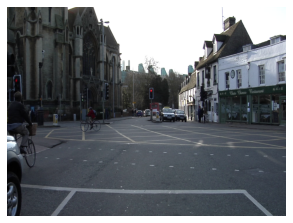

In [7]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))


In [8]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

<AxesSubplot:>

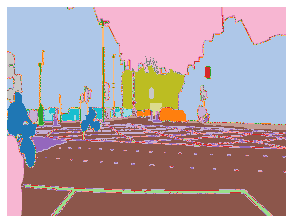

In [9]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)


In [10]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [22, 22, 22,  ..., 17, 17, 17],
        [22, 22, 22,  ..., 17, 17, 17],
        [22, 22, 22,  ..., 17, 17, 17]], dtype=torch.uint8)

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner


In [13]:
sz = msk.shape; sz


(720, 960)

In [14]:
half = tuple(int(x/2) for x in sz); half


(360, 480)

In [15]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])


In [16]:
dls = camvid.dataloaders(path/'images', bs=8)


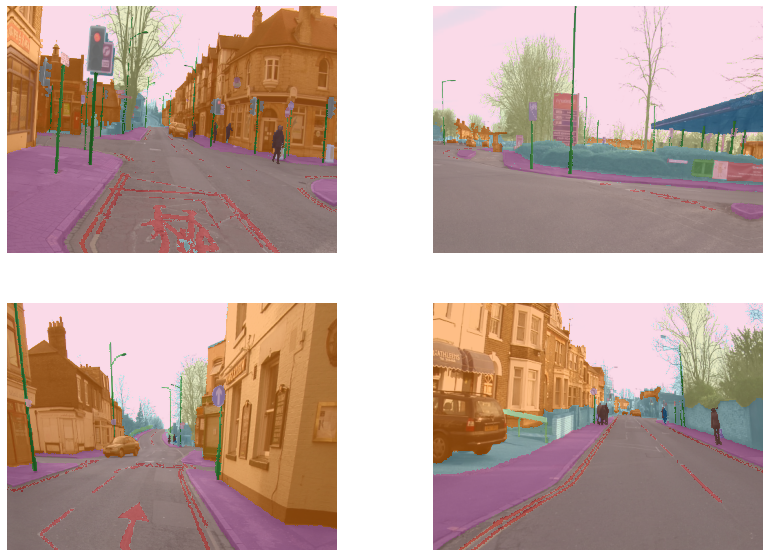

In [17]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [18]:
dls.vocab = codes

In [19]:
name2id = {v:k for k,v in enumerate(codes)}

In [20]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [21]:
void_code = name2id['Void']

In [22]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()


In [23]:
opt = ranger

In [24]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

SuggestedLRs(valley=0.00015848931798245758)

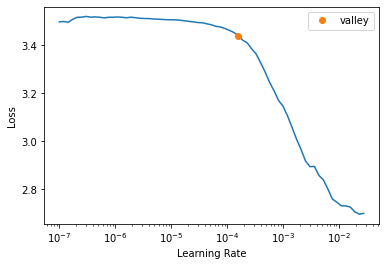

In [25]:
learn.lr_find()

In [26]:
# learn.fit_flat_cos(10,0.000275) 0.916380
learn.fit_one_cycle(10,0.000275)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.661704,1.622129,0.620400,00:33
1,1.247710,0.722012,0.826446,00:33
2,0.808044,0.586458,0.844028,00:33
3,0.623090,0.494929,0.865003,00:33
4,0.527307,0.425431,0.867786,00:33
5,0.458762,0.359834,0.894702,00:33
6,0.410517,0.367388,0.890907,00:33
7,0.377649,0.336040,0.901749,00:33
8,0.358115,0.329083,0.903762,00:33
9,0.346625,0.327619,0.904054,00:33


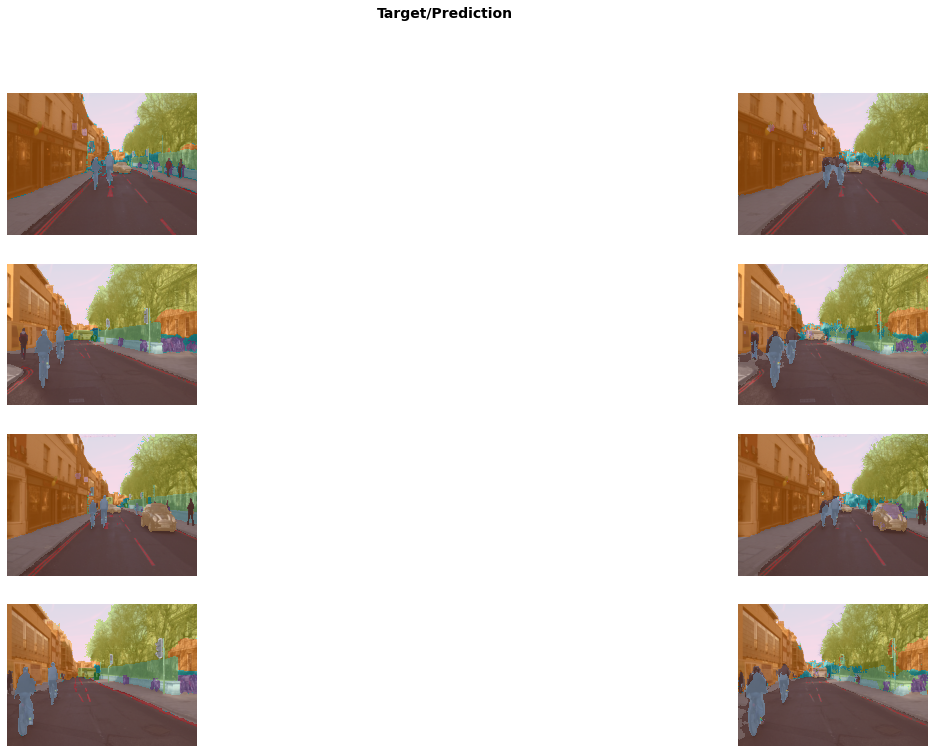

In [27]:
learn.show_results(max_n=4, figsize=(24,12))


In [30]:
learn.fit_one_cycle(10,0.000275/4)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.266796,0.290599,0.913583,00:33
1,0.275489,0.291201,0.913810,00:33
2,0.276028,0.294249,0.913289,00:33
3,0.272109,0.284083,0.915652,00:33
4,0.269612,0.281142,0.918188,00:33
5,0.262328,0.286479,0.915506,00:33
6,0.254802,0.297737,0.912594,00:33
7,0.249736,0.288990,0.914412,00:33
8,0.244644,0.290779,0.914166,00:33
9,0.242909,0.291022,0.914121,00:33


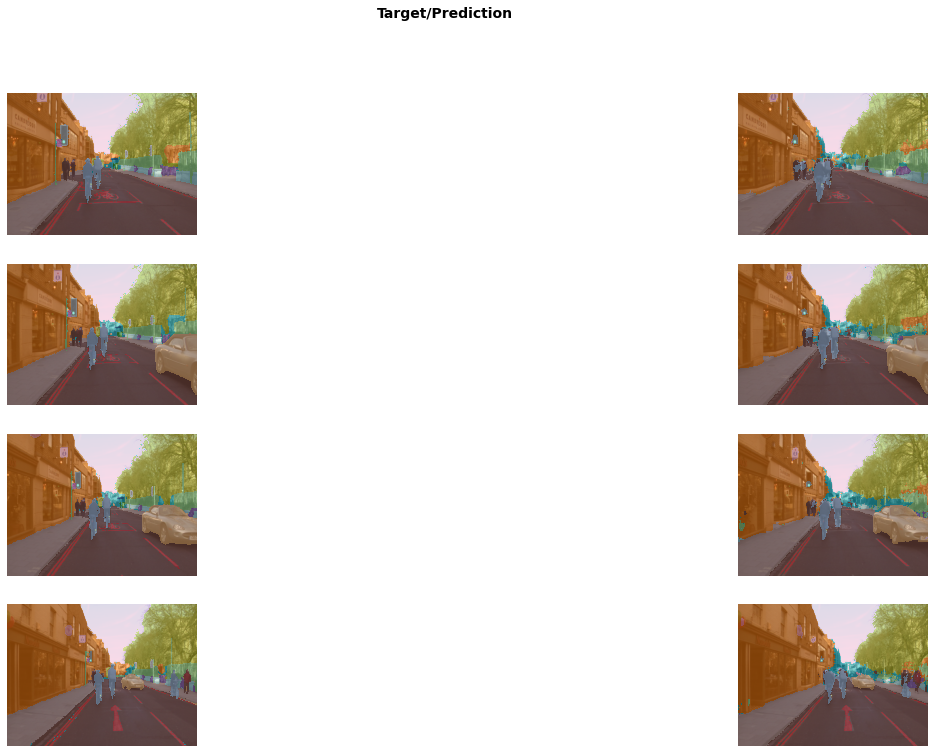

In [29]:
learn.show_results(max_n=4, figsize=(24,12))
